# __THEORY__

# __SEPP: _self-exciting point process extended to Covariates___


Self-exciting spatio-temporal point processes, an extension of temporal __Hawkes__ processes, model events whose rate depends on the past history of the process. The current conditional intensity $\lambda(t|\mathcal{H}_t)$ is determined by the past history $\mathcal{H}_t$ of the process.

$$\lambda(s, t|\mathcal{H}_t) = \mu(s) + \int_X \int_0^t g(s, t) dt\,ds $$ 
<br>
$$ \lambda(s, t) = \mu(s) + \sum_{i:t_i<t} g(s-s_i, t-t_i)$$
where,
$$ \mu(s) = e^{\beta X_{C(s)}}$$

- $\mu$: is a constant backgound rate of events
- $g(\cdot)$ is the triggering function
- $t_i$: is a point process of event times $t_i \in [0, T)$
- $\mathcal{H}_t$: all events up to time $t$

The events may be partitioned into disjoint processes: 
- __background process__ of cluster centers, which is simply a Poisson process with rate $\mu(s)$, and
- __offspring processes__ of triggered events inside each cluster, whose intensities are determined by $g$.

## __Expectation maximization algorithm SEPP__

This is a summary of the calculations to adjust the parameters of the model from the log likehood of the intensity function:
$$l_c(\Theta) = \sum_{i=1}^n \mathbb{1}(u_i=0)\beta X_{C(s)} + \sum_{i=1}^n \sum_{j=1}^n \mathbb{1}(u_i=j)\log(g(s_i-s_j, t_i-t_j)) - \int_0^T \int_X \lambda(s, t) ds dt
$$

### __Expectation step__

$$E[l_c(\Theta)] \le \sum_{responses\, i} \left[ P(u_i=0)\beta X_{C(x_i,y_i)}) + \sum_{t_j<t_i}P(u_i=j)\log\left(\frac{\theta_{M_j}}{2\pi \omega \sigma^2}e^{-(t_i-t_j)/\omega}\exp\left(-\frac{d_{i,j}^2}{2\sigma^2}\right)\right)\right] - T \sum_{cells\,i} A_i \exp(\beta X_i) - \sum_{crimes\,i} \theta_{M_i}(1-e^{-(T-t_i)/\omega})$$

- Where we have that the probabilities of the latent variables are:


$$P(u_i = j) = \frac{g(s_i-s_j, t_i-t_j)}{\lambda(s_i, t_i) },  \quad  t_j < t_i  $$
$$ zero\, in\, other\, case, and$$

$$P(u_i=0) = 1- \sum_{j=1}^{i-1} P(u_i=j) = \frac{\mu(s_i)}{\lambda(s_i, t_i)} $$ 

where, 

$$ \lambda(s, t) = e^{\beta X_{C(s)}} + \sum_{i:t_i<t} g(s-s_i, t-t_i)$$
 with:
$$ \mu(s_i) = e^{\beta X_{C(s_i)}}$$
and,
$$\sum_{i: t_i<t} g(s, t) = \sum_{i: t_i<t} \frac{1}{2\pi \omega \sigma} e^{-\frac{t-t_i}{\omega}} e^{-\frac{(x-x_i)^2+(y-y_i)^2}{2\sigma^2}}$$




### __Maximization step__ ###

Adjust parameter vector: $\Theta = \{\beta,\sigma^2,\omega,\theta_{M_j} \}$ using the derivative of the likelihood function and setting zero:
$$ \frac{ \partial E[l_c(\Theta)]}{\partial \beta} = 0$$

- __covariates__ $\pmb{\beta}$: The following expression is convex in $\beta$, so an algorithm can be used to maximize the standard numeric to find the maximum in each iteration:
$$\sum_{responses\,i} P(u_i=0)X_{C(x_i, y_i)} = T \sum_{cells\,i} A_i X_i\exp(\beta X_i) $$

- __Spatial decay__ $\pmb{\sigma^2}$: 
$$ \sigma^2 = \frac{\sum_{responses\,i}\sum_{t_j<t_i}P(u_i=j)d_{ij}^2}{2\sum_{responses\,i}\sum_{t_j<t_i}P(u_i=j)}$$

- __Temporal deacay__ $\pmb{\omega}$: 
$$ \omega = \frac{\sum_{i}\sum_{t_j<t_i}P(u_i=j)(t_i-t_j)-\sum_i \theta_{M_i}e^{-(T-t_i)/\omega}(t_i-T)}{\sum_{i}\sum_{t_j<t_i}P(u_i=j)} $$

- __Coefficients of foreground__ $\pmb{\theta_M}$
$$ \theta_L = \frac{\sum_{responses\,i}\sum_{t_j<t_i}P(u_i=j)\mathbb{I}(M_j=L)}{K_L - \sum_{crimes\,i}\mathbb{I}(M_i=L)e^{-(T-t_i)/\omega}} $$










In [1]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import random as rd
from random import randint

import timeit

from scipy.optimize import fsolve

e = math.e
pi = math.pi

def plt_events():
    '''
    function to draw the point process given a spatial positions x, y
    '''
    plt.plot(data.Long, data.Lat, '.')
    plt.plot([-4, 4, 0, 0, 0],[0,0,0,-4,4], 'steelblue')
    c=0
    for i, j in zip(data.Long, data.Lat):
        plt.plot([data.cx[c], i], [data.cy[c], j], 'r-o', linewidth=1)
        plt.text(i*1.15, j*1.15, str(c+1))
        plt.text(data.cx[c]+1, data.cy[c]+1.5, 'cov1=%1.2f\ncov2=%1.2f'%(data.cov1[c], data.cov2[c]), fontsize=10)
        c+=1
    plt.axis([-4, 4, -4, 4])
    plt.title('Spatial-distribution of incidents')
    plt.grid()

def plt_heatmap(data, tit, lbx, lby, ax):
    '''
    plt_heatmap plot a heatmap of matrix covariate
    ARGS:
      data: covariate matrix 
      tit: plot title
      lbx: x axis label 
      lby: y axis label
      ax: object handle of sub-plot 
    '''
    im = ax.imshow(data, cmap='copper', vmin=0.0, vmax=1.0)
    ax.set_xticks(list(range(len(lbx))))
    ax.set_yticks(list(range(len(lby))))
    ax.set_xticklabels(lbx)
    ax.set_yticklabels(lby)
    ax.set_title(tit)
    for i in range(len(lby)):
        for j in range(len(lbx)):
            text = ax.text(j, i, data[i][j], ha="center", va="center", color="w")
    plt.colorbar(im, ax=ax, shrink=0.5)


### __Expectation step__

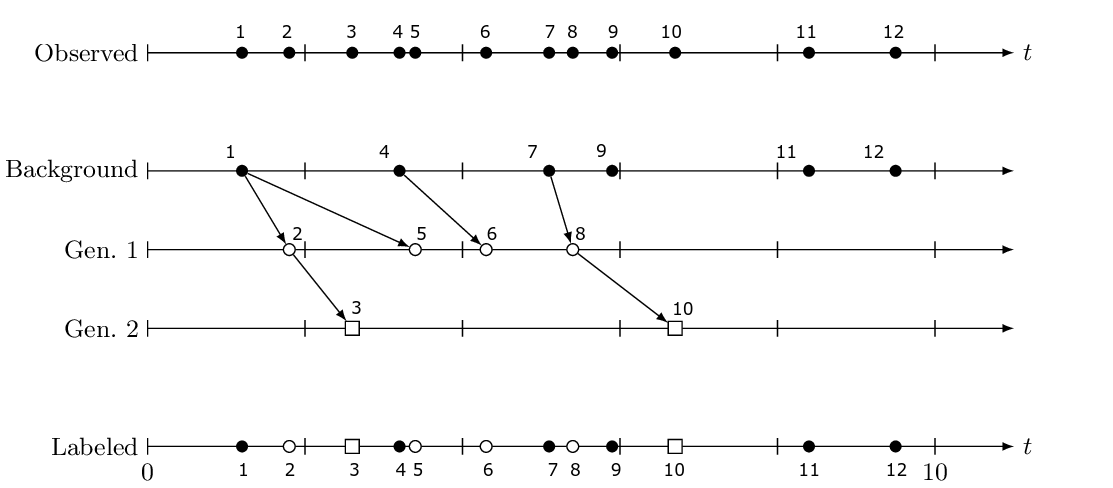

,Long,Lat,Time,Cell
0,3.367006,-0.813939,0.001325,3.0
1,-3.609325,-0.264551,0.023215,2.0
2,-2.176191,-2.369556,0.044954,2.0
3,3.983021,-0.659832,0.076306,3.0
4,-0.808490,-2.570276,0.125022,2.0
...,...,...,...,...
2995,-1.987446,-2.839542,49.936072,2.0
2996,-1.123133,-1.161998,49.947912,2.0
2997,2.357773,2.656297,49.954515,1.0
2998,3.550602,-0.222031,49.994004,3.0


,Cell,cx,cy,cov1,cov2
0,0,-2,2,0.26,0.07
1,1,2,2,0.23,0.46
2,2,-2,-2,0.24,0.42
3,3,2,-2,0.27,0.05


,Long,Lat,Time,Cell,cx,cy,cov1,cov2,dist
0,3.367006,-0.813939,0.001325,3.0,2,-2,0.27,0.05,3.275444
1,-3.609325,-0.264551,0.023215,2.0,-2,-2,0.24,0.42,5.601710
2,-2.176191,-2.369556,0.044954,2.0,-2,-2,0.24,0.42,0.167615
3,3.983021,-0.659832,0.076306,3.0,2,-2,0.27,0.05,5.728420
4,-0.808490,-2.570276,0.125022,2.0,-2,-2,0.24,0.42,1.744911
...,...,...,...,...,...,...,...,...,...
2995,-1.987446,-2.839542,49.936072,2.0,-2,-2,0.24,0.42,0.704989
2996,-1.123133,-1.161998,49.947912,2.0,-2,-2,0.24,0.42,1.471144
2997,2.357773,2.656297,49.954515,1.0,2,2,0.23,0.46,0.558727
2998,3.550602,-0.222031,49.994004,3.0,2,-2,0.27,0.05,5.565542


Program Executed in 5.318011875002412


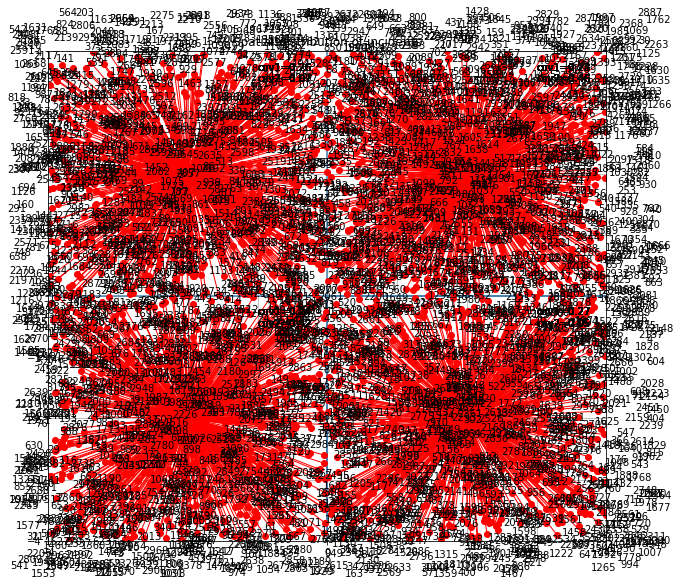

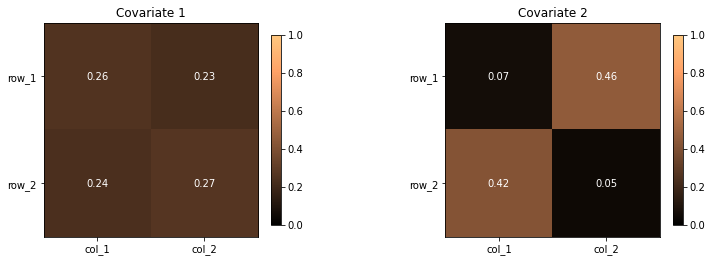

In [2]:
start = timeit.default_timer()
######################################################################


######################################
#             Parameters             #
######################################
number_events = 3000              # number of events      
omega = 10                        # temporary decay
sigma2 = 10                       # spatial decay
T = 300                           # temporal window of the experiment
sc = 1.5                          # size cell
beta = np.array([1,1])            # weight of covariates

cte1 = 1/(2*sigma2)
cte2 = 1/(2*pi*omega*sigma2)
cte3 = T*sc


######################################
#           Event Positions          #
######################################
x = np.array([])
for i in range(0, number_events):
  x = np.append(x, rd.uniform(-4.0, 4.0))

y = np.array([]) 
for i in range(0, number_events):
  y = np.append(y, rd.uniform(-4.0, 4.0))

######################################
#    Time of occurrence of events    #
######################################
t = np.array([])
for i in range(0, number_events):
  t = np.append(t, rd.uniform(0, 50)) 
  t.sort()  

######################################
#    Location of events in cells     #
######################################
A = np.array([])
for i in range(0, len(x)):
  if -4 < x[i] < 0 and 0 < y[i] < 4 :
    A = np.append(A, 0)
  if 0 < x[i] < 4 and 0 < y[i] < 4 :
    A = np.append(A, 1)
  if -4 < x[i] < 0 and -4 < y[i] < 0 :
    A = np.append(A, 2)
  if 0 < x[i] < 4 and -4 < y[i] < 0 :
    A = np.append(A, 3)
	
######################################
#   Values of covariates in cells    #
######################################
v1 = [0.26, 0.23, 0.24, 0.27]  # value of the covariate 1 in each cell
v2 = [0.07, 0.46, 0.42, 0.05]  # value of the covariate 2 in each cell
cx = [-2, 2, -2, 2]            # x coordinate of the center of cells
cy = [2, 2, -2, -2]            # y coordinate of the center of cells
######################################
#  Plots of the events in the cells  #
#    and heat map of covariates      #
######################################
ndx = np.array([0,1,2,3], dtype=np.int64) # cells

incidents = pd.DataFrame(data={'Long': x, 'Lat': y, 'Time': t, 'Cell': A})
cells = pd.DataFrame(data={'Cell': ndx, 'cx': cx, 'cy': cy, 'cov1': v1, 'cov2': v2})
data = incidents.merge(cells)
data.sort_values('Time', inplace=True)
data.reset_index(inplace=True, drop=True)
data['dist'] = (data.cx-data.Long)**2+(data.cy-data.Lat)**2

display(incidents)
display(cells)
display(data)
fig = plt.figure(figsize=(10,9))
plt_events()

C = [[[0.26, 0.23], [0.24, 0.27]], [[0.07, 0.46], [0.42, 0.05]]] # value of covariates in cell

lby = ['row_1', 'row_2']
lbx = ['col_1', 'col_2']
fig = plt.figure(figsize=(12,7))
ax = plt.subplot(1,2,1)
plt_heatmap(C[0], "Covariate 1", lbx, lby, ax)
ax = plt.subplot(1,2,2)
plt_heatmap(C[1], "Covariate 2", lbx, lby, ax)
plt.subplots_adjust(wspace=0.5)

###########################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds

### __Background with covariates__
> $ \mu(s) = e^{\beta X_{C(s)}} $.   This is the equation (3.1) of the Reinhart's thesis

### __Function $\sum g(s, t)$__

> $$\sum_{i: t_i<t} g(s, t) = \sum_{i: t_i<t} \frac{1}{2\pi \omega \sigma^2} e^{-\frac{t-t_i}{\omega}} e^{-\frac{(x-x_i)^2+(y-y_i)^2}{2\sigma^2}}$$

In [3]:
start = timeit.default_timer()
#################################################################################

#########################
#   mu for each cell    #
#########################
ncovs = 2                      # number of covariates    
covs  = cells.iloc[:,3:]       # df of covariates

Beta = np.ones(ncovs)
mu_cell   = e**((covs*Beta).sum(axis=1))
print(mu_cell)

#########################
# correlation function  #
#########################
def g(s, t, verb=False):
    df = data[(data.Time<t) & (data.Cell==s)]      
    if verb: display(df)
    s2 = -1/(2*sigma2)
    om = -1/omega
    dn = 1/(2*pi*omega*sigma2)
    timeDecay    = (e**(om*(t-df.Time)))
    #print(timeDecay)
    spatialDecay = (e**(s2*df.dist))
    #print(spatialDecay)
    return (timeDecay*spatialDecay*dn).sum()

print('g(0, 8.0) =', g(0, T, True))    
print('g(1, 8.0) =', g(1, T, True))
print('g(2, 8.0) =', g(2, T, True))
print('g(3, 8.0) =', g(3, T, True))


#################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds

0    1.390968
1    1.993716
2    1.934792
3    1.377128
dtype: float64


,Long,Lat,Time,Cell,cx,cy,cov1,cov2,dist
8,-2.470451,2.639954,0.150541,0.0,-2,2,0.26,0.07,0.630865
10,-2.568341,0.092000,0.155356,0.0,-2,2,0.26,0.07,3.963475
14,-0.475831,2.689088,0.196842,0.0,-2,2,0.26,0.07,2.797934
23,-0.017480,3.323077,0.330582,0.0,-2,2,0.26,0.07,5.680918
32,-3.860115,2.711785,0.408391,0.0,-2,2,0.26,0.07,3.966665
...,...,...,...,...,...,...,...,...,...
2971,-2.354039,2.297910,49.475091,0.0,-2,2,0.26,0.07,0.214094
2980,-1.487392,1.432342,49.589650,0.0,-2,2,0.26,0.07,0.585003
2981,-3.273282,1.202374,49.593312,0.0,-2,2,0.26,0.07,2.257454
2987,-2.777617,1.151677,49.718926,0.0,-2,2,0.26,0.07,1.324339


g(0, 8.0) = 2.659880325935422e-12


,Long,Lat,Time,Cell,cx,cy,cov1,cov2,dist
6,1.987775,0.152925,0.144137,1.0,2,2,0.23,0.46,3.411834
7,3.976874,1.927058,0.150539,1.0,2,2,0.23,0.46,3.913353
11,1.612827,0.750787,0.162978,1.0,2,2,0.23,0.46,1.710435
13,0.060030,2.518722,0.178094,1.0,2,2,0.23,0.46,4.032556
16,1.795672,0.586395,0.206451,1.0,2,2,0.23,0.46,2.040028
...,...,...,...,...,...,...,...,...,...
2975,1.554343,0.316976,49.527946,1.0,2,2,0.23,0.46,3.031182
2976,2.099311,0.158845,49.541567,1.0,2,2,0.23,0.46,3.399714
2985,2.758578,0.485387,49.620105,1.0,2,2,0.23,0.46,2.869493
2993,2.473095,3.872719,49.897781,1.0,2,2,0.23,0.46,3.730894


g(1, 8.0) = 2.7172831951782545e-12


,Long,Lat,Time,Cell,cx,cy,cov1,cov2,dist
1,-3.609325,-0.264551,0.023215,2.0,-2,-2,0.24,0.42,5.601710
2,-2.176191,-2.369556,0.044954,2.0,-2,-2,0.24,0.42,0.167615
4,-0.808490,-2.570276,0.125022,2.0,-2,-2,0.24,0.42,1.744911
5,-1.473140,-1.699415,0.141887,2.0,-2,-2,0.24,0.42,0.367933
12,-0.156722,-1.388006,0.175152,2.0,-2,-2,0.24,0.42,3.772211
...,...,...,...,...,...,...,...,...,...
2989,-2.059491,-0.428118,49.770137,2.0,-2,-2,0.24,0.42,2.474352
2990,-3.224423,-0.852861,49.802731,2.0,-2,-2,0.24,0.42,2.815140
2991,-0.457226,-0.352979,49.807626,2.0,-2,-2,0.24,0.42,5.092832
2995,-1.987446,-2.839542,49.936072,2.0,-2,-2,0.24,0.42,0.704989


g(2, 8.0) = 2.849477004356531e-12


,Long,Lat,Time,Cell,cx,cy,cov1,cov2,dist
0,3.367006,-0.813939,0.001325,3.0,2,-2,0.27,0.05,3.275444
3,3.983021,-0.659832,0.076306,3.0,2,-2,0.27,0.05,5.728420
9,1.184048,-1.444132,0.153101,3.0,2,-2,0.27,0.05,0.974767
15,3.381637,-0.084469,0.199348,3.0,2,-2,0.27,0.05,5.578182
17,2.274979,-1.088833,0.213879,3.0,2,-2,0.27,0.05,0.905839
...,...,...,...,...,...,...,...,...,...
2986,2.628053,-0.915638,49.660671,3.0,2,-2,0.27,0.05,1.570291
2988,3.706245,-0.273605,49.747834,3.0,2,-2,0.27,0.05,5.891713
2992,0.288349,-0.254325,49.895109,3.0,2,-2,0.27,0.05,5.977132
2998,3.550602,-0.222031,49.994004,3.0,2,-2,0.27,0.05,5.565542


g(3, 8.0) = 2.813083499795673e-12
Program Executed in 0.1391592469990428


Program Executed in 8.667036655002448


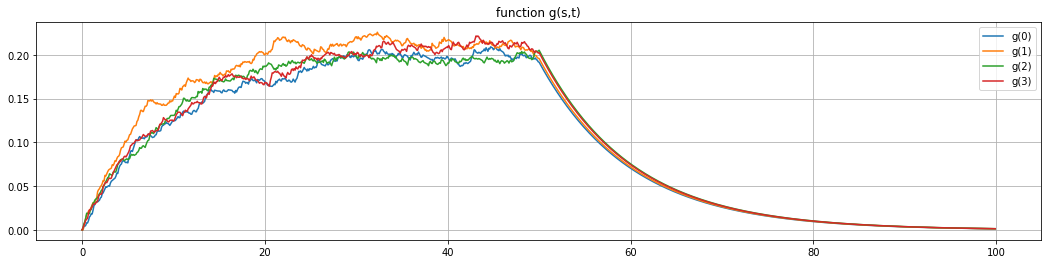

In [4]:
start = timeit.default_timer()
#################################################################################

res0 = [g(0, t*0.10) for t in range(1000)]
res1 = [g(1, t*0.10) for t in range(1000)]
res2 = [g(2, t*0.10) for t in range(1000)]
res3 = [g(3, t*0.10) for t in range(1000)]
x = [t*0.1 for t in range(1000)]
figure = plt.figure(figsize=(18, 4))
plt.plot(x, res0, x, res1, x, res2, x, res3)
plt.title('function g(s,t)')
plt.legend(['g(0)', 'g(1)', 'g(2)', 'g(3)'])
plt.grid()

#################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds

### __Probability of background__

> $$ Pr(u_i=0) = \frac{\mu(s_i)}{\lambda(s_i, t_i)}$$

>  $$ \lambda(s_i, t_i) = \mu(s_i) + \sum_{t_j<t_i}g(s_i-s_j, t_i-t_j) $$

### __Probability of Offprings__

> $$Pr(u_i = j) = \frac{g(s_i-s_j, t_i-t_j)}{\lambda(s_i, t_i)}, \quad \quad t_j<t_i$$


In [ ]:
start = timeit.default_timer()
#################################################################################

#cte1 = 1/(2*sigma2)
#cte2 = 1/(2*pi*omega*sigma2)

# square distance between events i and event j
dist2_ij = np.array([[(data.Long[i]-data.Long[j])**2+(data.Lat[i]-data.Lat[j])**2 for j in range(0,len(data))] 
                     for i in range(0,len(data))]) 

# kernel to know if event i is triggered by event j
g_ij = np.array([[e**(-(data.Time[i]-data.Time[j])/omega) * e**(-dist2_ij[i, j]*cte1) * cte2 
                  if data.Time[j] < data.Time[i] else 0 for j in range(0,len(data))] for i in range(0,len(data))]) 

# sum of kernels for each event i
sum_kernels = np.array([sum(g_ij[i]) for i in range(0,len(data))]) 

# background for the events i
#mu = np.array([e**((data[["cov1","cov2"]] * beta[0:2]).sum(axis=1)[i]+beta3) for i in range(0, len(data))])
mu = np.array([e**((data[["cov1","cov2"]] * beta).sum(axis=1)[i]) for i in range(0, len(data))])

# conditional intensity of the events i
Lambda = mu + sum_kernels

# Probability of event i to be triggered by event j
p_ij = np.array([[g_ij[i,j]/Lambda[i] for j in range(0, len(data))] for i in range(0, len(data))])

# probability of event i to be triggered for some event j
pte = sum_kernels/Lambda

# probability of background event
pbe = mu/Lambda

#################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds

## __CODE IMPLEMENTATION__

This code requires the definition of the following variables and data:
- __data__: incidents dataframe recorded with the following features: latitude, longitude, datetime, cell index, covariate1, covariate2, ..., covariate N
- __covs__: numpy matrix of covariates values (N events by C covariates)
- __ncovs__: number of covariates


In [ ]:
start = timeit.default_timer()
######################################################################

###############################
#   Declarations to improve   #
#       execution speed       #
###############################
lon = data.Long.to_numpy()
lat = data.Lat.to_numpy()
t = data.Time.to_numpy()
cov_ev = data[['cov1','cov2']].to_numpy()
data_ar = data.to_numpy()
covs_ar = covs.to_numpy()


# square distance between events i and event j
dist2_ij = np.array([[(lon[i]-lon[j])**2+(lat[i]-lat[j])**2 for j in range(0,len(data))] 
                     for i in range(0,len(data))]) 

###############################
#   Parameters optimization   #
###############################

############# beta optimization #############
def syst(beta):
  beta1 = beta[0]
  beta2 = beta[1]
  f1 = sum(pbe*data_ar[:,6])-cte3*sum(covs_ar[:,0]*e**(covs_ar*beta).sum(axis=1))
  f2 = sum(pbe*data_ar[:,7])-cte3*sum(covs_ar[:,1]*e**(covs_ar*beta).sum(axis=1))
  return (f1, f2)

def root_beta(beta):
  return fsolve(syst, beta)

############# sigma2 optimization #############
def update_sigma2(sigma2):
  """ function that updates the value of sigma2 """
  num_sigma2 = 0
  for i in range(0, len(data)):
    for j in range (0, len(data)):
      num_sigma2 +=  p_ij[i,j]*dist2_ij[i,j]
  sigma2 = 0.5*num_sigma2/sum(pte)
  return sigma2

############# omega optimization #############
def funct_omega(new_omega):
  term1, suma = 0, 0
  inew_omega = -1/new_omega
  """ function that calculates the right side of the omega optimization equation """
  for i in range(0, len(data)):
    for j in range(0, len(data)):
      term1 += p_ij[i,j]*(t[i]-t[j])
    suma += e**(inew_omega*(T-t[i])) * (T-t[i])
  return (suma+term1)/sum(pte)

def new_omega(omega):
  while abs(omega-funct_omega(omega)) > 1e-5:
    omega = funct_omega(omega);
  return omega
#################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds  

In [ ]:
start = timeit.default_timer()
######################################################################

n_iter = 200

for n in range(0, n_iter): 
  cte1 = 1/(2*sigma2)
  cte2 = 1/(2*pi*omega*sigma2)
  cte3 = T*sc
  # kernel to know if event i is triggered by event j
  iomega = 1/omega
  # correlation function between events i and j
  g_ij = np.array([[e**(-(t[i]-t[j])*iomega) * e**(-dist2_ij[i, j]*cte1) * cte2 
                    if t[j] < t[i] else 0 for j in range(0,len(data))] for i in range(0,len(data))]) 
  # sum of kernels for each event i
  sum_kernels = np.array([sum(g_ij[i]) for i in range(0,len(data))]) 
  # background for the events i
  mu = np.array([e**((cov_ev * beta).sum(axis=1)[i]) for i in range(0, len(data))])
  # conditional intensity of the events i
  Lambda = mu + sum_kernels
  # probability of event i to be triggered by event j
  p_ij = np.array([[g_ij[i,j]/Lambda[i] for j in range(0, len(data))] for i in range(0, len(data))])
  # probability of event i to be triggered for some event j
  pte = sum_kernels/Lambda
  # probability of background event
  pbe = mu/Lambda
  if (abs(omega-new_omega(omega)) > 1e-5):
    print('diferencia omega = {}'.format(abs(omega-new_omega(omega))))
    nomega = new_omega(omega)
    print('new omega = {}'.format(omega))
    print(n)
    print('------------') 
  else:
    pass
  if (abs(beta-root_beta(beta)).all()) > 1e-5:
    print('diferencia betas = {}'.format(abs(beta-root_beta(beta))))
    nbeta = root_beta(beta)
    print('new beta = {}'.format(beta))
    print(n)
    print('------------')
  else:
    pass
  if (abs(sigma2-update_sigma2(sigma2))) > 1e-5:
    print('diferencia sigma2 = {}'.format(abs(sigma2-update_sigma2(sigma2))))
    nsigma2 = update_sigma2(sigma2)
    print('new sigma2 = {}'.format(sigma2))
    print(n)
    print('------------') 
  else:
    pass
  omega = nomega
  beta = nbeta
  sigma2 = nsigma2
  
print('The beta value is:{}'.format(beta))
print('The sigma2 value is:{}'.format(sigma2))
print('The omega value is:{}'.format(omega))
#################################################################################
stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time)) # It returns time in seconds

## __Algunos experimentos ejecutados__

Número de eventos: 500

$\beta = [1,1]$ , $\omega =10$, $\sigma^2=10$, $T=100$, sz = 1.5, y obtenemos los valores    optimizados de $\beta=[-1.030, -0.317]$, $\sigma^2=0.171$ , $\omega=1.376$, con un tiempo de ejecución de 502.804 segundos. 

Número de eventos: 1000

$\beta = [1,1]$, $\omega =10$, $\sigma^2=10$, $T=100$, sz = 1.5, y obtenemos los valores    optimizados de $\beta=[0.966, 0.406]$, $\sigma^2=0.136$ , $\omega=2.019$, con un tiempo de ejecución de 2024.370 segundos.

Número de eventos: 2000

$\beta = [1,1]$, $\omega =10$, $\sigma^2=10$, $T=200$, sz = 1.5, y obtenemos los valores    optimizados de $\beta=[0.686, -0.072]$, $\sigma^2=0.195$ , $\omega=1.377$, con un tiempo de ejecución de 8377.846 segundos.      

